# Construct a Multi-Agent Workflow

Build a data agent that can perform web research, answer questions, and generate charts.

Let's load the environment variables that define the OpenAI API and Tavily API keys.

In [1]:
from dotenv import load_dotenv
_ = load_dotenv(override=True)

**Note**: These variables are already defined in this environment. If you'd like to run the notebook locally, you can define them in a `.env` file. For an env template, you can check the file `env.template` in this lesson's folder.

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>To access <code>requirements.txt</code>, <code>env.template</code>, <code>prompts.py</code>, and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

</div>

In [9]:
from typing import Dict, Any, List
from langchain_core.messages import HumanMessage

import json
from typing import Optional
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal, Optional, List, Dict, Any, Type

MAX_REPLANS = 2


# Custom State class with specific keys
class State(MessagesState):
    enabled_agents: Optional[List[str]]
    # Current plan only: mapping from step number (as string) to step definition
    plan: Optional[Dict[str, Dict[str, Any]]]
    user_query: Optional[str]
    current_step: int
    replan_flag: Optional[bool]
    last_reason: Optional[str]
    # Replan attempts tracked per step number
    replan_attempts: Optional[Dict[int, int]]
    agent_query: Optional[str]


MAX_REPLANS = 2


def get_agent_descriptions() -> Dict[str, Dict[str, Any]]:
    """
    Return structured agent descriptions with capabilities and guidelines.
    Edit this function to change how the planner/executor reason about agents.
    """
    return {
        "web_researcher": {
            "name": "Web Researcher",
            "capability": "Fetch public data via Tavily web search",
            "use_when": "Public information, news, current events, or external facts are needed",
            "limitations": "Cannot access private/internal company data",
            "output_format": "Raw research data and findings from public sources",
        },
        "cortex_researcher": {
            "name": "Cortex Researcher",
            "capability": "Query private/company data in Snowflake, including structured deal records (company name, deal value, sales rep, close date, deal status, product line) and unstructured sales meeting notes, via Snowflake Cortex Agents.",
            "use_when": "Internal documents, company databases, or private data access is required",
            "limitations": "Cannot access public web data",
            "output_format": "For structured requests, return the exact fields and include SQL when applicable; for unstructured, return concise relevant excerpts with citations.",
        },
        "chart_generator": {
            "name": "Chart Generator",
            "capability": "Build visualizations from structured data",
            "use_when": "User explicitly requests charts, graphs, plots, visualizations (keywords: chart, graph, plot, visualise, bar-chart, line-chart, histogram, etc.)",
            "limitations": "Requires structured data input from previous steps",
            "output_format": "Visual charts and graphs",
            "position_requirement": "Must be used as final step after data gathering is complete",
        },
        "chart_summarizer": {
            "name": "Chart Summarizer",
            "capability": "Summarize and explain chart visualizations",
            "use_when": "After chart_generator has created a visualization",
            "limitations": "Requires a chart as input",
            "output_format": "Written summary and analysis of chart content",
        },
        "synthesizer": {
            "name": "Synthesizer",
            "capability": "Write comprehensive prose summaries of findings",
            "use_when": "Final step when no visualization is requested - combines all previous research",
            "limitations": "Requires research data from previous steps",
            "output_format": "Coherent written summary incorporating all findings",
            "position_requirement": "Should be used as final step when no chart is needed",
        },
    }


def _get_enabled_agents(state: State | None = None) -> List[str]:
    """Return enabled agents; if absent, use baseline/default.

    Supports both dict-style and attribute-style state objects.
    """
    baseline = ["web_researcher", "chart_generator", "chart_summarizer", "synthesizer"]
    if not state:
        return baseline
    val = state.get("enabled_agents") if hasattr(state, "get") else getattr(state, "enabled_agents", None)

    if isinstance(val, list) and val:
        allowed = {"web_researcher", "cortex_researcher", "chart_generator", "chart_summarizer", "synthesizer"}
        filtered = [a for a in val if a in allowed]
        return filtered
    return baseline


def format_agent_list_for_planning(state: State | None = None) -> str:
    """
    Format agent descriptions for the planning prompt.
    """
    descriptions = get_agent_descriptions()
    enabled_list = _get_enabled_agents(state)
    agent_list = []

    for agent_key, details in descriptions.items():
        if agent_key not in enabled_list:
            continue
        agent_list.append(f"  • `{agent_key}` – {details['capability']}")

    return "\n".join(agent_list)


def format_agent_guidelines_for_planning(state: State | None = None) -> str:
    """
    Format agent usage guidelines for the planning prompt.
    """
    descriptions = get_agent_descriptions()
    enabled = set(_get_enabled_agents(state))
    guidelines = []

    # Cortex vs Web researcher (only include guidance for enabled agents)
    if "cortex_researcher" in enabled:
        guidelines.append(f"- Use `cortex_researcher` when {descriptions['cortex_researcher']['use_when'].lower()}.")
    if "web_researcher" in enabled:
        guidelines.append(f"- Use `web_researcher` for {descriptions['web_researcher']['use_when'].lower()}.")

    # Chart generator specific rules
    if "chart_generator" in enabled:
        chart_desc = descriptions['chart_generator']
        cs_hint = " A `chart_summarizer` should be used to summarize the chart." if "chart_summarizer" in enabled else ""
        guidelines.append(
            f"- **Include `chart_generator` _only_ if {chart_desc['use_when'].lower()}**. If included, `chart_generator` must be {chart_desc['position_requirement'].lower()}. Visualizations should include all of the data from the previous steps that is reasonable for the chart type.{cs_hint}")

    # Synthesizer default
    if "synthesizer" in enabled:
        synth_desc = descriptions['synthesizer']
        guidelines.append(
            f"  – Otherwise use `synthesizer` as {synth_desc['position_requirement'].lower()}, and be sure to include all of the data from the previous steps.")

    return "\n".join(guidelines)


def format_agent_guidelines_for_executor(state: State | None = None) -> str:
    """
    Format agent usage guidelines for the executor prompt.
    """
    descriptions = get_agent_descriptions()
    enabled = _get_enabled_agents(state)
    guidelines = []

    if "web_researcher" in enabled:
        web_desc = descriptions['web_researcher']
        guidelines.append(f"- Use `\"web_researcher\"` when {web_desc['use_when'].lower()}.")
    if "cortex_researcher" in enabled:
        cortex_desc = descriptions['cortex_researcher']
        guidelines.append(f"- Use `\"cortex_researcher\"` for {cortex_desc['use_when'].lower()}.")

    return "\n".join(guidelines)


def plan_prompt(state: State) -> HumanMessage:
    """
    Build the prompt that instructs the LLM to return a high‑level plan.
    """
    replan_flag = state.get("replan_flag", False)
    user_query = state.get("user_query", state["messages"][0].content)
    prior_plan = state.get("plan") or {}
    replan_reason = state.get("last_reason", "")

    # Get agent descriptions dynamically

    agent_list = format_agent_list_for_planning(state)
    agent_guidelines = format_agent_guidelines_for_planning(state)

    enabled_list = _get_enabled_agents(state)

    # Build planner agent enum based on enabled agents
    enabled_for_planner = [
        a for a in enabled_list
        if a in ("web_researcher", "cortex_researcher", "chart_generator", "synthesizer")
    ]
    planner_agent_enum = " | ".join(enabled_for_planner) or "web_researcher | chart_generator | synthesizer"

    prompt = f"""
        You are the **Planner** in a multi‑agent system.  Break the user's request
        into a sequence of numbered steps (1, 2, 3, …).  **There is no hard limit on
        step count** as long as the plan is concise and each step has a clear goal.

        You may decompose the user's query into sub-queries, each of which is a
        separate step.  Break the query into the smallest possible sub-queries
        so that each sub-query is answerable with a single data source.
        For example, if the user's query is "What were the key
        action items in the last quarter, and what was a recent news story for 
        each of them?", you may break it into steps:

        1. Fetch the key action items in the last quarter.
        2. Fetch a recent news story for the first action item.
        3. Fetch a recent news story for the second action item.
        4. Fetch a recent news story for the last action item

        Here is a list of available agents you can call upon to execute the tasks in your plan. You may call only one agent per step.

        {agent_list}

        Return **ONLY** valid JSON (no markdown, no explanations) in this form:

        {{
        "1": {{
            "agent": "{planner_agent_enum}",
            "action": "string",
        }},
        "2": {{ ... }},
        "3": {{ ... }}
        }}

        Guidelines:
        {agent_guidelines}
        """

    if replan_flag:
        prompt += f"""
        The current plan needs revision because: {replan_reason}

        Current plan:
        {json.dumps(prior_plan, indent=2)}

        When replanning:
        - Focus on UNBLOCKING the workflow rather than perfecting it.
        - Only modify steps that are truly preventing progress.
        - Prefer simpler, more achievable alternatives over complex rewrites.
        """

    else:
        prompt += "\nGenerate a new plan from scratch."

    prompt += f'\nUser query: "{user_query}"'

    return HumanMessage(content=prompt)


def executor_prompt(state: State) -> HumanMessage:
    """
    Build the single‑turn JSON prompt that drives the executor LLM.
    """
    step = int(state.get("current_step", 0))
    latest_plan: Dict[str, Any] = state.get("plan") or {}
    plan_block: Dict[str, Any] = latest_plan.get(str(step), {})
    max_replans = MAX_REPLANS
    attempts = (state.get("replan_attempts", {}) or {}).get(step, 0)

    # Get agent guidelines dynamically
    executor_guidelines = format_agent_guidelines_for_executor(state)
    plan_agent = plan_block.get("agent", "web_researcher")

    messages_tail = (state.get("messages") or [])[-4:]

    executor_prompt = f"""
        You are the **executor** in a multi‑agent system with these agents:
        `{'`, `'.join(sorted(set([a for a in _get_enabled_agents(state) if a in ['web_researcher', 'cortex_researcher', 'chart_generator', 'chart_summarizer', 'synthesizer']] + ['planner'])))}`.

        **Tasks**
        1. Decide if the current plan needs revision.  → `"replan_flag": true|false`
        2. Decide which agent to run next.             → `"goto": "<agent_name>"`
        3. Give one‑sentence justification.            → `"reason": "<text>"`
        4. Write the exact question that the chosen agent should answer
                                                    → "query": "<text>"

        **Guidelines**
        {executor_guidelines}
        - After **{MAX_REPLANS}** failed replans for the same step, move on.
        - If you *just replanned* (replan_flag is true) let the assigned agent try before
        requesting another replan.

        Respond **only** with valid JSON (no additional text):

        {{
        "replan": <true|false>,
        "goto": "<{'|'.join([a for a in _get_enabled_agents(state) if a in ['web_researcher', 'cortex_researcher', 'chart_generator', 'chart_summarizer', 'synthesizer']] + ['planner'])}>",
        "reason": "<1 sentence>",
        "query": "<text>"
        }}

        **PRIORITIZE FORWARD PROGRESS:** Only replan if the current step is completely blocked.
        1. If any reasonable data was obtained that addresses the step's core goal, set `"replan": false` and proceed.
        2. Set `"replan": true` **only if** ALL of these conditions are met:
        • The step has produced zero useful information
        • The missing information cannot be approximated or obtained by remaining steps
        • `attempts < {max_replans}`
        3. When `attempts == {max_replans}`, always move forward (`"replan": false`).

        ### Decide `"goto"`
        - If `"replan": true` → `"goto": "planner"`.
        - If current step has made reasonable progress → move to next step's agent.
        - Otherwise execute the current step's assigned agent (`{plan_agent}`).

        ### Build `"query"`
        Write a clear, standalone instruction for the chosen agent. If the chosen agent 
        is `web_researcher` or `cortex_researcher`, the query should be a standalone question, 
        written in plain english, and answerable by the agent.

        Ensure that the query uses consistent language as the user's query.

        Context you can rely on
        - User query ..............: {state.get("user_query")}
        - Current step index ......: {step}
        - Current plan step .......: {plan_block}
        - Just‑replanned flag .....: {state.get("replan_flag")}
        - Previous messages .......: {messages_tail}

        Respond **only** with JSON, no extra text.
        """

    return HumanMessage(
        content=executor_prompt
    )


def agent_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

## 2.1 Initialize the agent's state

State provides the agent with a shared, evolving memory across nodes so that the agents have the context and instructions needed to act coherently and achieve the goal.

In [2]:
from typing import Literal, Optional, List, Dict, Any, Type
from langgraph.graph import MessagesState

# Custom State class with specific keys
class State(MessagesState):
    user_query: Optional[str] # The user's original query
    enabled_agents: Optional[List[str]] # Makes our multi-agent system modular on which agents to include
    plan: Optional[List[Dict[int, Dict[str, Any]]]] # Listing the steps in the plan needed to achieve the goal.
    current_step: int # Marking the current step in the plan.
    agent_query: Optional[str] # Inbox note: `agent_query` tells the next agent exactly what to do at the current step.
    last_reason: Optional[str] # Explains the executor’s decision to help maintain continuity and provide traceability.
    replan_flag: Optional[bool] # Set by the executor to indicate that the planner should revise the plan.
    replan_attempts: Optional[Dict[int, Dict[int, int]]] # Replan attempts tracked per step number.

**Note**: `State` inherits from `MessagesState`, which is defined with a single `messages` key that keeps track of the list of messages shared among agents. So in addition to the fields you just defined for `State`, it also has a `messages` field from `MessagesState`. 

## 2.2 Create planner

The planner takes in the user's query and generates a plan. The plan consists of a sequence of numbered steps; each step includes the action and the sub-agent that is assigned to that action.

In [3]:
# from prompts import plan_prompt
from langgraph.types import Command
from langchain_core.messages import HumanMessage

# from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama
import json

In [4]:
import re
from typing import Any, List
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage, AIMessage


class JsonSafeChatOllama:
    """
    Wrapper around ChatOllama that enforces JSON-only output.
    """

    def __init__(self, model: str, temperature: float = 0):
        self.llm = ChatOllama(
            model=model,
            temperature=temperature,
        )

    def _sanitize(self, text: str) -> str:
        # Remove <think>...</think>
        text = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)

        # Remove markdown code fences
        text = re.sub(r"```(?:json)?|```", "", text)

        return text.strip()

    def invoke(self, messages: List[BaseMessage], **kwargs) -> AIMessage:
        raw = self.llm.invoke(messages, **kwargs)

        content = raw.content
        if not isinstance(content, str):
            content = str(content)

        clean = self._sanitize(content)

        return AIMessage(
            content=clean,
            additional_kwargs=raw.additional_kwargs,
        )


In [5]:
# import JsonSafeChatOllama

reasoning_llm = JsonSafeChatOllama(
    model="deepseek-r1:14b",
    temperature=0,
)


In [6]:

from langchain_ollama import ChatOllama
# reasoning_llm = ChatOpenAI(
#     model="o3",
#     model_kwargs={"response_format": {"type": "json_object"}},
# )

# Initialize your Supervisor
# reasoning_llm = ChatOllama(
#     model="deepseek-r1:14b", 
#     temperature=0,
#     model_kwargs={"response_format": {"type": "json_object"}},
# )


In [7]:
# Initialize your Supervisor
llm = ChatOllama(
    model="mistral", 
    temperature=0
)

In [8]:
def planner_node(state: State) -> Command[Literal['executor']]:
    """
    Runs the planning LLM and stores the resulting plan in state.
    """
    # 1. Invoke LLM with the planner prompt
    llm_reply = reasoning_llm.invoke([plan_prompt(state)])

    # 2. Validate JSON
    try:
        content_str = llm_reply.content if isinstance(
            llm_reply.content, str) else str(llm_reply.content)
        parsed_plan = json.loads(content_str)
    except json.JSONDecodeError:
        raise ValueError(
            f"Planner returned invalid JSON:\n{llm_reply.content}")

    # 3. Store as current plan only
    replan = state.get("replan_flag", False)
    updated_plan: Dict[str, Any] = parsed_plan

    return Command(
        update={
            "plan": updated_plan,
            "messages": [HumanMessage(
                content=llm_reply.content,
                name="replan" if replan else "initial_plan")],
            "user_query": state.get("user_query", state["messages"][0].content),"current_step": 1 if not replan else state["current_step"],
            # Preserve replan flag so executor runs planned agent
            # once before reconsidering
            "replan_flag": state.get("replan_flag", False),
            "last_reason": "",
            "enabled_agents": state.get("enabled_agents"),
        },
        goto="executor",
    )

## 2.3 Create executor

The executor executes the plan by identifying the sub-agent that should go next and generating the instructions (or agent query) for the chosen agent. Based on the results of the retrieval step (web search results in this case), the executor might decide that the plan needs to be changed. In this case, it goes back to the planner and asks it to generate an updated plan.

In [10]:
# from prompts import executor_prompt
from langgraph.graph import END

MAX_REPLANS = 3

In [11]:
def executor_node(
    state: State,
) -> Command[Literal["web_researcher", "chart_generator", "synthesizer", "planner"]]:

    plan: Dict[str, Any] = state.get("plan", {})
    step: int = state.get("current_step", 1)

    # 0) If we *just* replanned, 
    # run the planned agent once before reconsidering.
    if state.get("replan_flag"):
        planned_agent = plan.get(str(step), {}).get("agent")
        return Command(
            update={
                "replan_flag": False,
                "current_step": step + 1,  # advance because we executed the planned agent
            },
            goto=planned_agent,
        )

    # 1) Build prompt & call LLM
    llm_reply = reasoning_llm.invoke([executor_prompt(state)])
    try:
        content_str = llm_reply.content if isinstance(llm_reply.content, str) else str(llm_reply.content)
        parsed = json.loads(content_str)
        replan: bool = parsed["replan"]
        goto: str   = parsed["goto"]
        reason: str = parsed["reason"]
        query: str  = parsed["query"]
    except Exception as exc:
        raise ValueError(f"Invalid executor JSON:\n{llm_reply.content}") from exc

    # Upodate the state
    updates: Dict[str, Any] = {
        "messages": [HumanMessage(content=llm_reply.content, name="executor")],
        "last_reason": reason,
        "agent_query": query,
    }

    # Replan accounting
    replans: Dict[int, int] = state.get("replan_attempts", {}) or {}
    step_replans = replans.get(step, 0)

    # 2) Replan decision
    if replan:
        if step_replans < MAX_REPLANS:
            replans[step] = step_replans + 1
            updates.update({
                "replan_attempts": replans,
                "replan_flag": True,     # ensure next turn executes the planned agent once
                "current_step": step,    # stay on same step for the new plan
            })
            return Command(update=updates, goto="planner")
        else:
            # Cap hit: skip this step; let next step (or synthesizer) handle termination
            next_agent = plan.get(str(step + 1), {}).get("agent", "synthesizer")
            updates["current_step"] = step + 1
            return Command(update=updates, goto=next_agent)

    # 3) Happy path: run chosen agent; advance only if following the plan
    planned_agent = plan.get(str(step), {}).get("agent")
    updates["current_step"] = step + 1 if goto == planned_agent else step
    updates["replan_flag"] = False
    return Command(update=updates, goto=goto)

## 2.4 Create Web research agent

The web research sub-agent is a [ReAct agent](https://arxiv.org/abs/2210.03629) that uses [Tavily Search tool](https://python.langchain.com/docs/integrations/tools/tavily_search/) to search the web and answer the sub-query assigned to it. 

In [12]:
# "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"

In [13]:
from langgraph.prebuilt import create_react_agent
from typing import Literal
from langchain_tavily import TavilySearch
# from langchain_openai import ChatOpenAI

tavily_tool = TavilySearch(max_results=5)

tavily_tool.invoke("What is JP Morgan's stock price?")['results']

C:\Users\Sridhar\Documents\0. GRAXELLA\6.Intelligent_market_analyst\market_analyst\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
C:\Users\Sridhar\Documents\0. GRAXELLA\6.Intelligent_market_analyst\market_analyst\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


[{'url': 'https://www.tradingview.com/symbols/NYSE-JPM/',
  'title': 'JP Morgan Chase & Co. - Stocks - TradingView',
  'content': 'The current price of JPM is 327.91 USD — it has decreased by −0.38% in the past 24 hours. Watch JP Morgan Chase & Co. stock price performance more closely on',
  'score': 0.89053273,
  'raw_content': None},
 {'url': 'https://tradingeconomics.com/jpm:us',
  'title': 'JPMorgan | JPM - Stock Price | Live Quote | Historical Chart',
  'content': '| US500 | 6940 |  | 22.26 | 0.32% | 16.23% | Dec/26 |. | US30 | 48753 |  | 288.75 | 0.60% | 13.40% | Dec/26 |. Looking back, over the last four weeks, JPMorgan gained 8.64 percent. JPMorgan Chase & Co. is a financial holding company engaged in investment banking, financial services and asset management. **JPMorgan Stock Price Hits 4-week High**. Over the past 4 weeks, J.P. Morgan Chase gained 3.3%, and in the last 12 months, it increased 33.33%. **JPMorgan Stock Price Hits 4-week Low**. Over the past 4 weeks, J.P. Morga

In [14]:
def agent_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


# Research agent and node
web_search_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=agent_system_prompt(f"""
        You are the Researcher. You can ONLY perform research 
        by using the provided search tool (tavily_tool). 
        When you have found the necessary information, end your output.  
        Do NOT attempt to take further actions.
    """),
)

C:\Users\Sridhar\AppData\Local\Temp\ipykernel_10344\347938749.py:14: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_search_agent = create_react_agent(


In [15]:
agent_response = web_search_agent.invoke(
    {"messages":"what is jp morgan's current market cap?"})

In [16]:
agent_response['messages'][-1].content

' FINAL ANSWER: To find the current market capitalization of JP Morgan, I used the tavily_search function with the following parameters: query="JP Morgan market cap", topic="finance", search_depth="advanced". The results showed that as of [insert date], the market capitalization of JP Morgan was approximately [insert number] USD.'

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
    <p>🚨 &nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Also, the answer depends on the web search results since the question asks for current market cap.

In [17]:
def web_research_node(
    state: State,
) -> Command[Literal["executor"]]:
    agent_query = state.get("agent_query")
    result = web_search_agent.invoke({"messages":agent_query})
    goto = "executor"
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="web_researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

## 2.5 Create charting agent

If the user asks for the results to be charted, then the charting sub-agent can help with that. It first generates the Python code that generates the chart, and then executes the code using the `python_repl_tool`.

In [18]:
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from typing import Annotated, Literal, Optional, List, Dict, Any, Type


# create a python repl tool for importing in the lessons
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. You will be used to execute python code
    that generates charts. Only print the chart once.
    This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = (
        f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    )
    return (
        result_str
        + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, 
# WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=agent_system_prompt(
        """
        You can only generate charts. You are working with a researcher 
        colleague.
        1) Print the chart first.
        2) Save the chart to a file in the current working directory.
        3) At the very end of your message, output EXACTLY two lines 
        so the summarizer can find them:
           CHART_PATH: <relative_path_to_chart_file>
           CHART_NOTES: <one concise sentence summarizing the main insight in the chart>
        Do not include any other trailing text after these two lines.
        """
    ),
)

C:\Users\Sridhar\AppData\Local\Temp\ipykernel_10344\3267671467.py:32: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_agent = create_react_agent(


In [19]:
def chart_node(state: State) -> Command[Literal["chart_summarizer"]]:
    result = chart_agent.invoke(state)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    goto="chart_summarizer"
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

## 2.6 Create chart summary agent

This sub-agent generates a caption describing the chart generated by the chart generator.

In [20]:
chart_summary_agent = create_react_agent(
    llm,
    tools=[],  # Add image processing tools if available/needed.
    prompt=agent_system_prompt(
        "You can only generate image captions. You are working with a researcher colleague and a chart generator colleague. "
        + "Your task is to generate a standalone, concise summary for the provided chart image saved at a local PATH, where the PATH should be and only be provided by your chart generator colleague. The summary should be no more than 3 sentences and should not mention the chart itself."
    ),
)

C:\Users\Sridhar\AppData\Local\Temp\ipykernel_10344\2052520548.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_summary_agent = create_react_agent(


In [21]:
def chart_summary_node(
    state: State,
) -> Command[Literal[END]]:
    result = chart_summary_agent.invoke(state)
    print(f"Chart summarizer answer: {result['messages'][-1].content}")
    # Send to the end node
    goto = END
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
            "final_answer": result["messages"][-1].content,
        },
        goto=goto,
    )

## 2.7 Create a Synthesizer (Text Summarizer) Agent

In the case where the user does not ask for the results to be charted, the synthesizer sub-agent generates text that summarizes the retrieved results (in this case, the web search results).

In [22]:
# llm = ChatOpenAI(model="gpt-4o")

In [23]:
def synthesizer_node(state: State) -> Command[Literal[END]]:
    """
    Creates a concise, human‑readable summary of the entire interaction,
    **purely in prose**.

    It ignores structured tables or chart IDs and instead rewrites the
    relevant agent messages (research results, chart commentary, etc.)
    into a short final answer.
    """
    # Gather informative messages for final synthesis
    relevant_msgs = [
        m.content for m in state.get("messages", [])
        if getattr(m, "name", None) in ("web_researcher", 
                                        "chart_generator", 
                                        "chart_summarizer")
    ]

    user_question = state.get("user_query", state.get("messages", [{}])[0].content if state.get("messages") else "")

    synthesis_instructions = (
        """
        You are the Synthesizer. Use the context below to directly 
        answer the user's question. Perform any lightweight calculations, 
        comparisons, or inferences required. Do not invent facts not 
        supported by the context. If data is missing, say what's missing
        and, if helpful, offer a clearly labeled best-effort estimate 
        with assumptions.\n\n
        Produce a concise response that fully answers the question, with 
        the following guidance:\n
        - Start with the direct answer (one short paragraph or a tight bullet list).\n
        - Include key figures from any 'Results:' tables (e.g., totals, top items).\n
        - If any message contains citations, include them as a brief 'Citations: [...]' line.\n
        - Keep the output crisp; avoid meta commentary or tool instructions.
        """
        )

    summary_prompt = [
        HumanMessage(content=(
            f"User question: {user_question}\n\n"
            f"{synthesis_instructions}\n\n"
            f"Context:\n\n" + "\n\n---\n\n".join(relevant_msgs)
        ))
    ]

    llm_reply = llm.invoke(summary_prompt)

    answer = llm_reply.content.strip()
    print(f"Synthesizer answer: {answer}")

    return Command(
        update={
            "final_answer": answer,
            "messages": [HumanMessage(content=answer, name="synthesizer")],
        },
        goto=END,           # hand off to the END node
    )

## 2.8 Build the agent graph

In [24]:
from langgraph.graph import START, StateGraph

workflow = StateGraph(State)
workflow.add_node("planner", planner_node)
workflow.add_node("executor", executor_node)
workflow.add_node("web_researcher", web_research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("chart_summarizer", chart_summary_node)
workflow.add_node("synthesizer", synthesizer_node)

workflow.add_edge(START, "planner")

graph = workflow.compile()

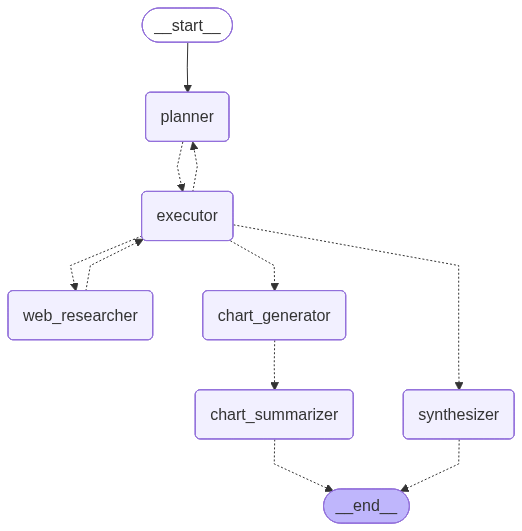

In [25]:
graph

In [112]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_png()))

## 2.9 Use the agent

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> The following two queries might take <b>2-5 minutes</b> to output the results.</p>

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
<p>🚨 &nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results may differ from those shown in the video. For example: 

In the first query, the agent might decide to call the synthesizer instead of calling the chart generator. In this case, you will only see text summarizing the web search results instead of a chart, which means the agent's answer is not completely relevant to the user's query. This is what you'll learn how to evaluate in the next lessons.
</p>

In [ ]:
# from langchain.schema import HumanMessage
import json

query = "Chart the current market capitalization of the top 5 banks in the US?"
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["web_researcher", "chart_generator", 
                               "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

Query: Chart the current market capitalization of the top 5 banks in the US?


In [114]:
query = "Identify current regulatory changes for the financial services industry in the US."
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["web_researcher", "chart_generator", 
                               "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

Query: Identify current regulatory changes for the financial services industry in the US.
Synthesizer answer: 1. Secure and Fair Enforcement (SAFE) Banking Act: This bill is aimed at protecting banks that work with state-legal marijuana businesses from federal penalties, providing them access to banking services.

2. Consumer Financial Protection Bureau (CFPB) Payday Lending Rule: The CFPB has proposed changes to the payday lending rule, which could allow for more frequent loan rollovers and less stringent underwriting standards.

3. Financial Stability Oversight Council (FSOC) Designation of Nonbank Financial Companies: The FSOC is reviewing whether to designate additional nonbank financial companies as systemically important financial institutions (SIFIs), subjecting them to stricter regulations.

4. Comprehensive Capital Analysis and Review (CCAR): This annual stress test conducted by the Federal Reserve evaluates the resilience of large banks under adverse economic conditions, help